In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import itertools
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
from PIL import Image

/Users/hyunseo.lee/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/hyunseo.lee/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/hyunseo.lee/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN3c1017RegisterOperatorsD1Ev)
  Referenced from: '/Users/hyunseo.lee/anaconda3/lib/python3.11/site-packages/torchvision/image.so'
  Expected in: '/Users/hyunseo.lee/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# load ddi and HAM10000 data
ddi_data_dir = "../data/ddi_cropped"
print(len(os.listdir(ddi_data_dir)))

ham_data_dir = "../data/HAM10000"
print(len(os.listdir(ham_data_dir)))

657
10016


In [3]:
# label the data according to their information
ddi_label_file = os.path.join(ddi_data_dir, "ddi_metadata.csv")
ham_label_file = os.path.join(ham_data_dir, "HAM10000_metadata.csv")
df_ddi = pd.read_csv(ddi_label_file)
df_ham = pd.read_csv(ham_label_file)
print("ddi description file:\n", df_ddi.head())
print("___________________________________")
print("ham description file:\n", df_ham.head())

ddi description file:
    Unnamed: 0  DDI_ID    DDI_file  skin_tone  malignant  \
0           0       1  000001.png         56       True   
1           1       2  000002.png         56       True   
2           2       3  000003.png         56       True   
3           3       4  000004.png         56       True   
4           4       5  000005.png         12       True   

                           disease  
0                 melanoma-in-situ  
1                 melanoma-in-situ  
2                mycosis-fungoides  
3  squamous-cell-carcinoma-in-situ  
4             basal-cell-carcinoma  
___________________________________
ham description file:
      lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM

In [4]:
class DDIDataset(Dataset):
    def __init__(self, data_dir, csv_file, transform=None, skin_threshold=35, file_list=None):
        """
        Args:
            data_dir (str): file directory with all the DDI images.
            csv_file (str): path to the ddi_metadata.csv file with annotations.
            transform (callable): transform applied on a sample.
            skin_threshold (int): threshold to decide light or dark skin tone.
        """
        df = pd.read_csv(csv_file)
        if file_list is not None:
            df = df[df["DDI_file"].isin(file_list)].reset_index(drop=True)
        self.df = df
        self.data_dir = data_dir
        self.transform = transform
        self.skin_threshold = skin_threshold

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.data_dir, row["DDI_file"])
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        skin_lbl = 0 if row["skin_tone"] < self.skin_threshold else 1
        malignant = int(row["malignant"])
        return img, skin_lbl, malignant

In [5]:
class HAMDataset(Dataset):
    def __init__(self, data_dir, csv_file, transform=None, file_list=None):
        """
        Args:
          data_dir (str): path to folder containing HAM10000 images
          csv_file (str): path to HAM10000_metadata.csv
          transform (callable): torchvision transforms to apply
          file_list (list[str]): list of filenames to include
        """
        self.data_dir  = data_dir
        self.transform = transform

        df = pd.read_csv(csv_file)
        df["image_id"] = df["image_id"].astype(str)
        self.meta = df.set_index("image_id")

        files = [
            f for f in os.listdir(data_dir)
            if os.path.splitext(f)[1].lower() in {".jpg", ".jpeg", ".png"}
        ]
        if file_list is not None:
            files = [f for f in files if f in file_list]
        self.image_files = sorted(files)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        fname = self.image_files[idx]
        image_id, _ = os.path.splitext(fname)

        row = self.meta.loc[image_id]
        dx = row["dx"].strip().lower()
        malignant = int(dx == "melanoma")

        img = Image.open(os.path.join(self.data_dir, fname)).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, malignant

In [6]:
# data splitting
# train: 60%, val: 20%, test: 20%
def split_data(data_dir, train_ratio=0.6, val_ratio=0.2):
    all_files = os.listdir(data_dir)
    num_files = len(all_files)
    
    train_size = int(num_files * train_ratio)
    val_size = int(num_files * val_ratio)
    
    train_files = all_files[:train_size]
    val_files = all_files[train_size:train_size + val_size]
    test_files = all_files[train_size + val_size:]
    
    return train_files, val_files, test_files

train_files_ddi, val_files_ddi, test_files_ddi = split_data(ddi_data_dir)
train_files_ham, val_files_ham, test_files_ham = split_data(ham_data_dir)

print("number of train images for ddi:", len(train_files_ddi))
print("number of val images for ddi:", len(val_files_ddi))
print("number of test images for ddi:", len(test_files_ddi))
print("------------------------------")
print("number of train images for ham:", len(train_files_ham))
print("number of val images for ham:", len(val_files_ham))
print("number of test images for ham:", len(test_files_ham))

number of train images for ddi: 394
number of val images for ddi: 131
number of test images for ddi: 132
------------------------------
number of train images for ham: 6009
number of val images for ham: 2003
number of test images for ham: 2004


In [7]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomGrayscale(0.2),
    transforms.ToTensor(),
])

eval_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

In [8]:
# data loading with transformations initialized above
def load_data_ddi(data_dir, csv_file, file_list, transform, batch_size, skin_threshold=35):
    ds = DDIDataset(data_dir, csv_file, transform=transform, skin_threshold=skin_threshold, file_list=file_list)
    return DataLoader(ds, batch_size=batch_size, shuffle=True)

def load_data_ham(data_dir, csv_file, file_list, transform, batch_size):
    ds = HAMDataset(data_dir, csv_file, transform=transform, file_list=file_list)
    return DataLoader(ds, batch_size=batch_size, shuffle=True)

def display_image(image_tensor):
    # display tensor image
    image = transforms.ToPILImage()(image_tensor)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

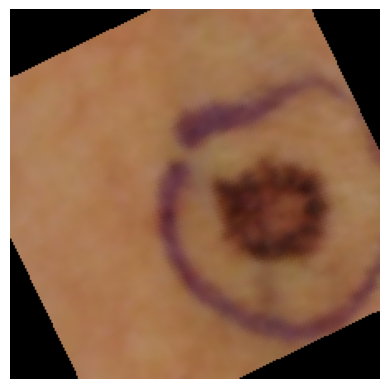

Skin Tone: 1, Malignant: 0


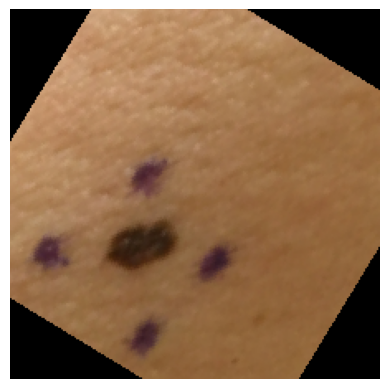

Skin Tone: 0, Malignant: 0


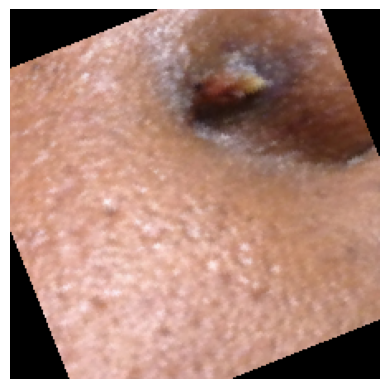

Skin Tone: 1, Malignant: 0


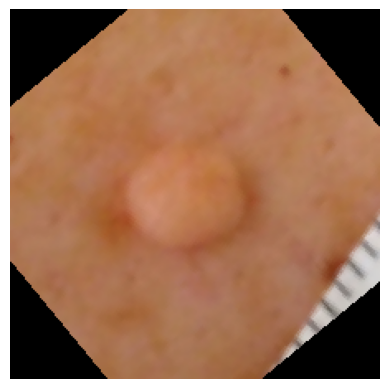

Skin Tone: 0, Malignant: 0


In [9]:
batch_size = 32
ddi_loader_train, ddi_loader_val, ddi_loader_test = [
    load_data_ddi(
        ddi_data_dir,
        ddi_label_file,
        files,
        transform,
        batch_size
    )
    for files, transform in [
        (train_files_ddi, train_transform),
        (val_files_ddi,   eval_transform),
        (test_files_ddi,  eval_transform),
    ]
]

ham_loader_train, ham_loader_val, ham_loader_test = [
    load_data_ham(
        ham_data_dir,
        ham_label_file,
        files,
        transform,
        batch_size
    )
    for files, transform in [
        (train_files_ham, train_transform),
        (val_files_ham,   eval_transform),
        (test_files_ham,  eval_transform),
    ]
]

# display some images
for images, skin_labels, malignant_labels in ddi_loader_train:
    for i in range(4):
        display_image(images[i])
        print(f"Skin Tone: {skin_labels[i]}, Malignant: {malignant_labels[i]}")
    break
